In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [17]:
sdss = Table.read('sdss_m2_period.txt', format='ascii')

In [18]:
sdss

ID,IAU NAME,M2,porb,M2e,porbe
int64,str24,float64,float64,float64,float64
64,SDSSJ005245.11-005337.2,0.319,2.735,0.09,0.002
81,SDSSJ011009.09+132616.1,0.319,7.984495,0.09,3e-06
117,SDSSJ013851.54-001621.6,0.255,1.746529272,0.124,1e-09
127,SDSSJ015225.38-005808.5,0.196,2.1519468,0.085,9.9e-06
170,SDSSJ022503.02+005456.2,0.294,21.86,0.09,0.16
182,SDSSJ023804.39-000545.7,0.38,5.0801,0.072,0.0048
189,SDSSJ024642.55+004137.2,0.38,17.43,0.072,0.04
217,SDSSJ030308.35+005444.1,0.287,3.226505,0.107,1e-06
229,SDSSJ031404.98-011136.6,0.319,6.32,0.09,0.02


<ErrorbarContainer object of 3 artists>

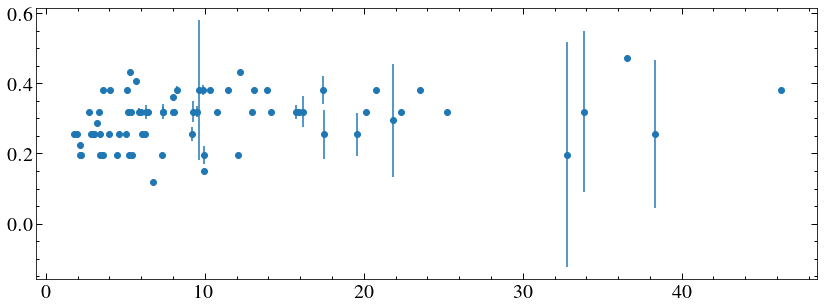

In [21]:
plt.errorbar(sdss['porb'], sdss['M2'], xerr=sdss['M2e'], yerr=sdss['porbe'], marker='o', ls='none')
#plt.errorbar()

In [22]:
period = 4.226953752501198
pe = 0.2
m2 = 0.08224821973550357
m2e = 0.009135699983472514

(0, 30)

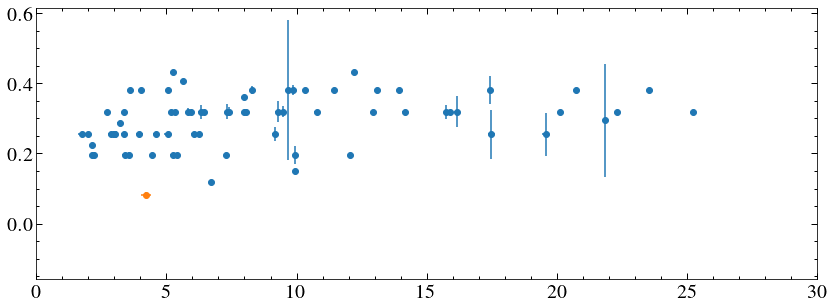

In [24]:
plt.errorbar(sdss['porb'], sdss['M2'], xerr=sdss['M2e'], yerr=sdss['porbe'], marker='o', ls='none')
plt.errorbar(period, m2, xerr=pe, yerr=m2e, marker='o', ls='none')
plt.xlim(0, 30)